# **Importaciones**

In [2]:
import shap, pickle
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from pdpbox import pdp
from rulefit import RuleFit
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

C:\Users\Nieves F\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Leer Data**

In [72]:
df = pd.read_csv('../data/Innova_2022.csv', encoding='utf-8', index_col=0)
df = df.T
df.head()

,Global Innovation Index,Innovation Input Sub-index,Innovation Output Sub-index,Institutions,Political environment,Political and operational stability,Government effectiveness,Regulatory environment,Regulatory quality,Rule of law,...,"Cultural and creative services exports, % total trade",National feature films/mn pop. 15ñ69,Entertainment and media market/th pop. 15ñ69,"Printing and other media, % manufacturing","Creative goods exports, % total trade",Online creativity,Generic top-level domains (TLDs)/th pop. 15ñ69,Country-code TLDs/th pop. 15ñ69,GitHub commits/mn pop. 15ñ69,Mobile app creation/bn PPP$ GDP
Albania,24.4,35.3,13.6,51.4,57.9,69.1,46.8,59.2,50.9,36.8,...,36.1,8.3,0.0,100.0,0.5,3.9,6.7,3.5,4.9,0.5
Algeria,16.7,26.7,6.7,47.2,47.4,56.4,38.4,50.4,12.7,25.8,...,0.3,0.9,0.8,4.0,0.1,0.7,0.5,0.1,2.2,0.1
Angola,13.9,21.1,6.8,41.9,43.0,61.8,24.3,51.1,22.3,21.1,...,0.0,0.0,0.0,60.6,0.1,0.1,0.0,0.1,0.2,0.0
Argentina,28.6,35.6,21.6,47.6,54.3,63.6,45.0,44.1,30.8,33.9,...,30.0,32.5,4.5,0.0,1.1,5.9,3.1,6.3,7.4,6.8
Armenia,26.6,34.3,18.9,59.7,54.4,61.8,47.0,68.8,51.2,43.9,...,10.3,0.0,0.0,39.8,9.0,6.6,3.1,5.1,8.0,10.1


In [5]:
keys = df.keys()

keys_x = []
X_Angola = [[]]

for i in keys:
  if i != ' Global Innovation Index' and \
     i != ' Innovation Input Sub-index' and \
     i != ' Innovation Output Sub-index':
    keys_x.append(i)
    X_Angola[0].append(df[i]['Angola'])

np.random.seed(42)  # Para la toma de decisión entre varios 

X = df[keys_x]
Y = df[' Global Innovation Index'].values
X_Angola = np.array(X_Angola)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=(3/10), random_state=0)

In [6]:
with open('../data/models/RF_minmax.pkl', 'rb') as f:
    model = pickle.load(f)

# **Explicaciones Globales**

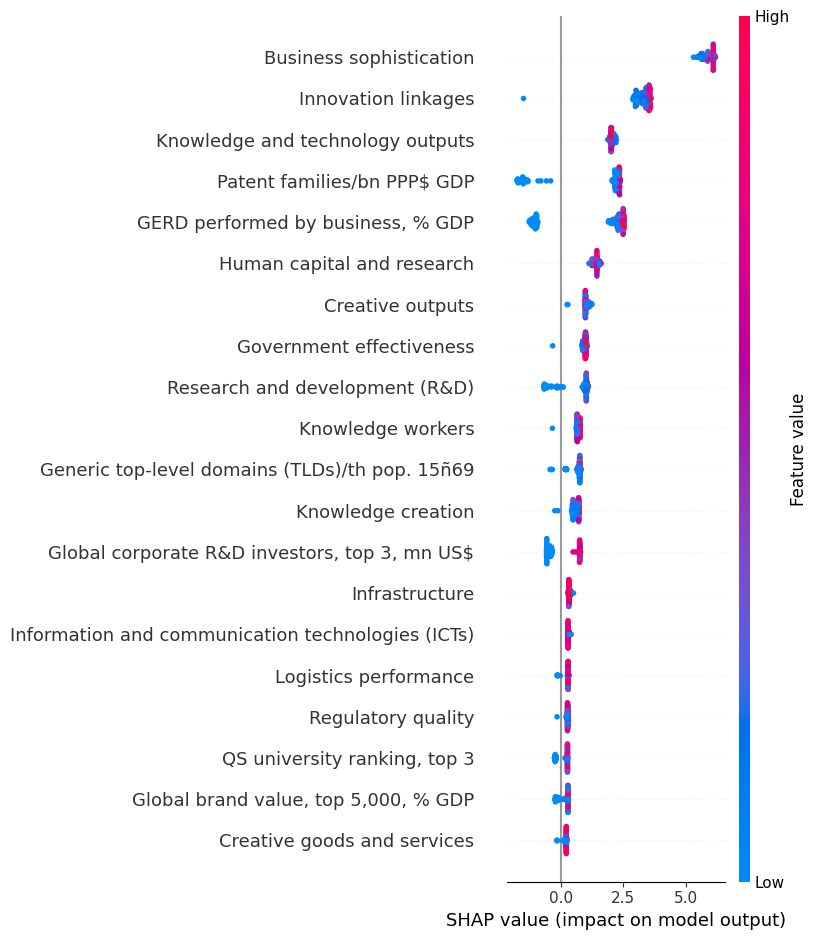

In [6]:
# Crear el explicador
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Resumen global: Importancia de características
shap.summary_plot(shap_values, X, feature_names=keys_x)

In [36]:
# Calcular la profundidad mínima de cada característica en cada árbol
feature_depths = {feature: [] for feature in range(X.shape[1])}

# Crear un DataFrame para registrar la profundidad mínima acumulada
depth_per_tree = pd.DataFrame(index=range(model.n_estimators), columns=X.columns)

for tree_idx, tree in enumerate(model.estimators_):
    # Calcular la profundidad de cada nodo
    node_depth = np.zeros(tree.tree_.node_count, dtype=np.int32)
    stack = [(0, -1)]  # Nodo raíz (id=0), profundidad inicial -1

    while stack:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth + 1

        if tree.tree_.feature[node_id] != -2:  # -2 indica nodos hoja
            stack.append((tree.tree_.children_left[node_id], depth + 1))
            stack.append((tree.tree_.children_right[node_id], depth + 1))

    # Guardar la profundidad mínima por característica
    for node_id in range(tree.tree_.node_count):
        feature = tree.tree_.feature[node_id]
        if feature != -2:
            feature_depths[feature].append(node_depth[node_id])

    # Calcular el promedio acumulado hasta el árbol actual
    for feature in feature_depths:
        depth_per_tree.iloc[tree_idx, feature] = np.mean(feature_depths[feature])

# Asegurarse de que los datos sean numéricos
depth_per_tree = depth_per_tree.astype(float)

# Calcular la media final de profundidad para cada característica
mean_depths = depth_per_tree.mean()

# Seleccionar los 10 mejores valores (menor profundidad promedio)
top_10_features = mean_depths.nsmallest(10)
tail_10_features = mean_depths.nlargest(10)

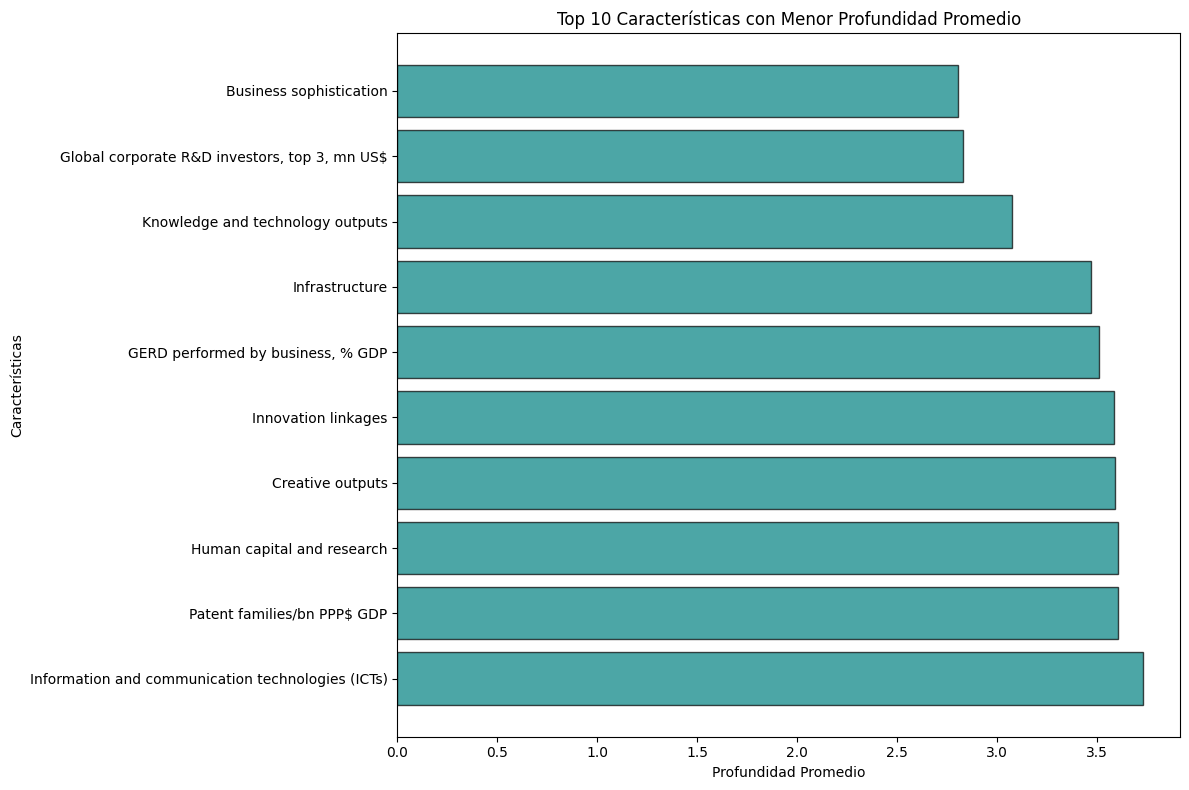

In [38]:
# Filtrar el DataFrame para solo los 10 mejores valores
filtered_depths = depth_per_tree[top_10_features.index]

# Graficar: Barras horizontales para los 10 mejores valores
plt.figure(figsize=(12, 8))
bar_width = 0.7  # Anchura de las barras

# Graficar la media de las profundidades de los 10 mejores valores
plt.barh(
    top_10_features.index,  # Características en el eje Y
    top_10_features.values,  # Profundidad promedio para cada característica
    color='teal',  # Color de las barras
    alpha=0.7,  # Transparencia para las barras
    edgecolor="black"
)

# Etiquetas y título
plt.xlabel('Profundidad Promedio')
plt.ylabel('Características')
plt.title('Top 10 Características con Menor Profundidad Promedio')

# Ajustar diseño
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

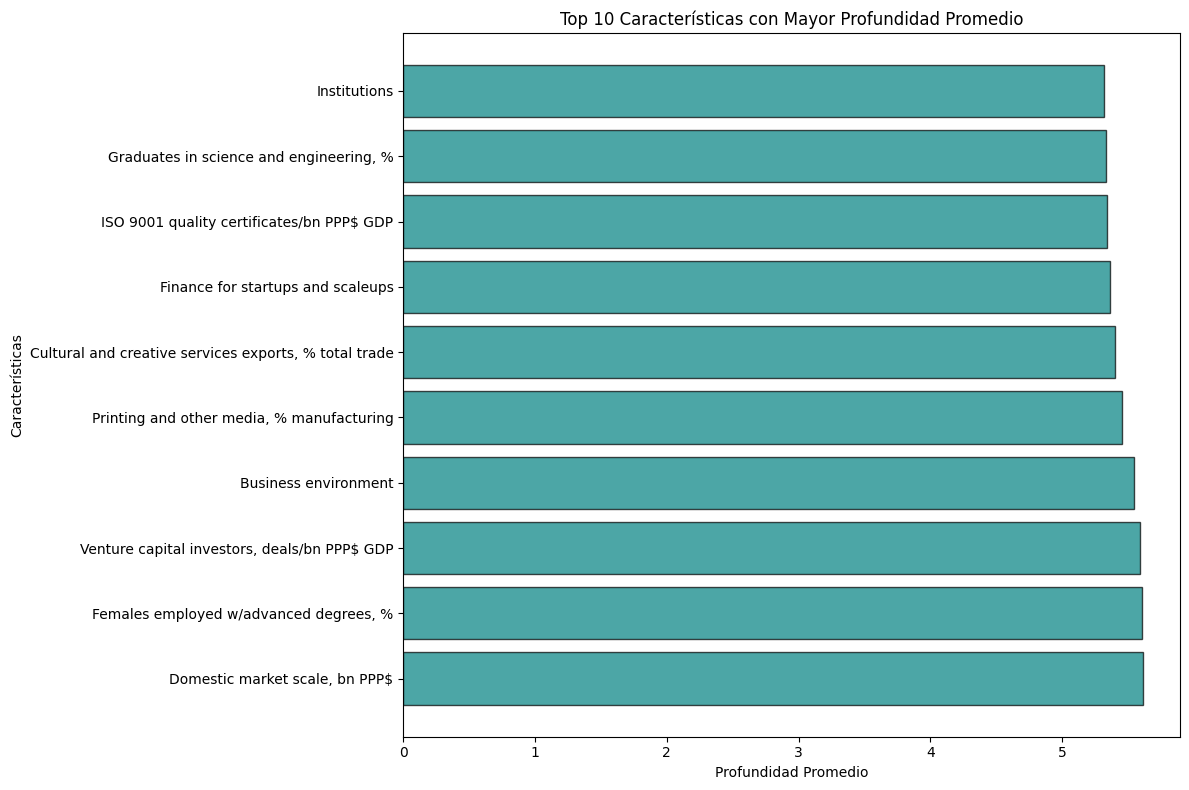

In [39]:
# Filtrar el DataFrame para solo los 10 mejores valores
filtered_depths = depth_per_tree[tail_10_features.index]

# Graficar: Barras horizontales para los 10 mejores valores
plt.figure(figsize=(12, 8))
bar_width = 0.7  # Anchura de las barras

# Graficar la media de las profundidades de los 10 mejores valores
plt.barh(
    tail_10_features.index,  # Características en el eje Y
    tail_10_features.values,  # Profundidad promedio para cada característica
    color='teal',  # Color de las barras
    alpha=0.7,  # Transparencia para las barras
    edgecolor="black"
)

# Etiquetas y título
plt.xlabel('Profundidad Promedio')
plt.ylabel('Características')
plt.title('Top 10 Características con Mayor Profundidad Promedio')

# Ajustar diseño
plt.tight_layout()
plt.show()

In [32]:
# Calcular la profundidad mínima de cada característica
feature_depths = {feature: [] for feature in range(X.shape[1])}

for tree in model.estimators_:
    # Profundidad de cada nodo en el árbol
    node_depth = np.zeros(shape=tree.tree_.node_count, dtype=np.int32)
    stack = [(0, -1)]  # Nodo raíz (id=0), profundidad inicial -1

    # Recorrer el árbol
    while stack:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth + 1

        # Si no es nodo hoja, explorar los hijos
        if tree.tree_.feature[node_id] != -2:  # -2 significa nodo hoja
            stack.append((tree.tree_.children_left[node_id], depth + 1))
            stack.append((tree.tree_.children_right[node_id], depth + 1))

    # Asignar la profundidad mínima de las características
    for node_id in range(tree.tree_.node_count):
        feature = tree.tree_.feature[node_id]
        if feature != -2:  # Ignorar nodos hoja
            feature_depths[feature].append(node_depth[node_id])

# Calcular la profundidad mínima promedio por característica
minimal_depth = {X.columns[feature]: np.mean(depths) for feature, depths in feature_depths.items()}

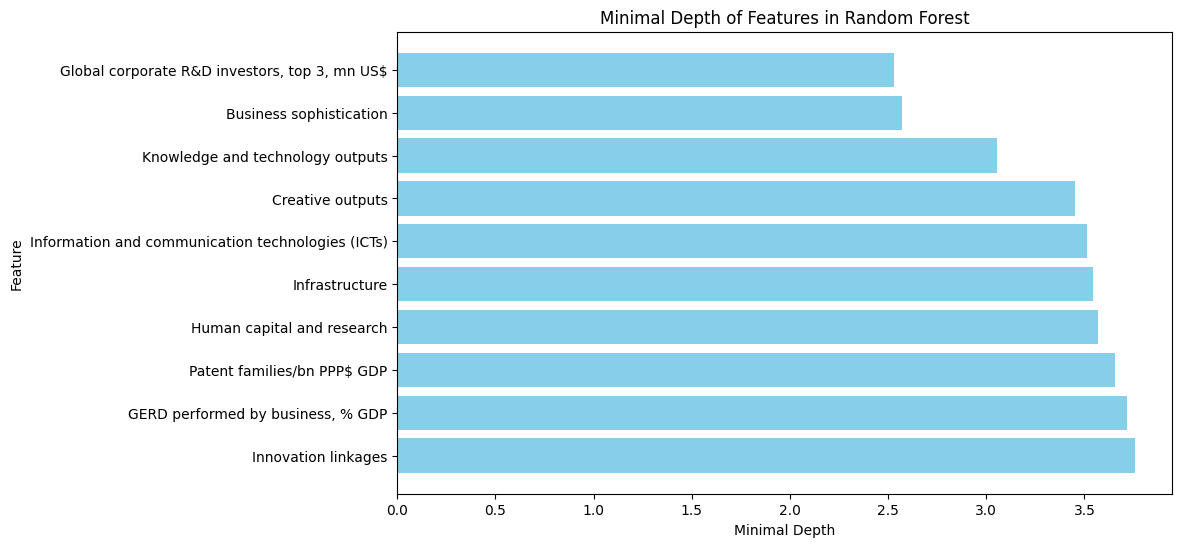

In [19]:
# Crear un DataFrame para graficar
depth_df = pd.DataFrame({
    'Feature': list(minimal_depth.keys()),
    'Minimal Depth': list(minimal_depth.values())
}).sort_values(by='Minimal Depth')

top_10 = depth_df.head(10)
# Graficar
plt.figure(figsize=(10, 6))
plt.barh(top_10['Feature'], top_10['Minimal Depth'], color='skyblue')
plt.xlabel('Minimal Depth')
plt.ylabel('Feature')
plt.title('Minimal Depth of Features in Random Forest')
plt.gca().invert_yaxis()
plt.show()

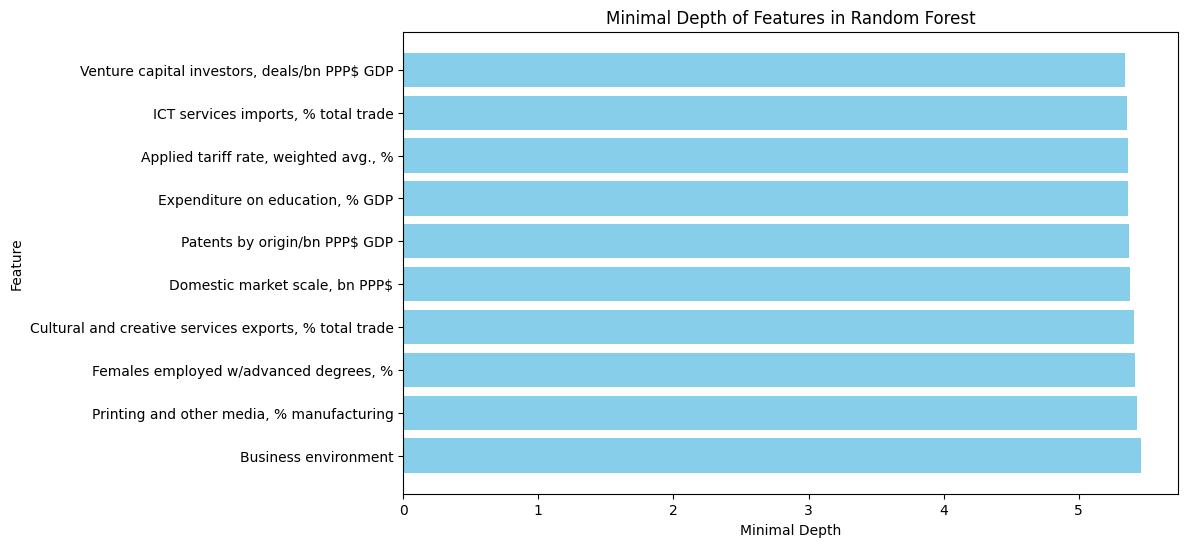

In [20]:
tail_10 = depth_df.tail(10)
# Graficar
plt.figure(figsize=(10, 6))
plt.barh(tail_10['Feature'], tail_10['Minimal Depth'], color='skyblue')
plt.xlabel('Minimal Depth')
plt.ylabel('Feature')
plt.title('Minimal Depth of Features in Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [50]:
# 2. PDP para una característica individual
pdp_feature = pdp.pdp_isolate(
    model=model, 
    dataset=X_test, 
    model_features=X.columns
)

# Graficar PDP
pdp.pdp_plot(pdp_feature, feature_name='MedInc')
plt.show()

# 3. PDP para la interacción entre dos características
pdp_interaction = pdp.pdp_interact(
    model=model, 
    dataset=X_test, 
    model_features=X.columns, 
    features=['MedInc', 'AveRooms']  # Características a analizar
)

# Graficar PDP de interacción
pdp.pdp_interact_plot(pdp_interaction, features=['MedInc', 'AveRooms'], plot_type='grid')
plt.show()

AttributeError: module 'pdpbox.pdp' has no attribute 'pdp_isolate'

In [54]:
# Generar combinaciones de 'Business sophistication' 'Innovation linkages'
medinc_values = np.linspace(X_test['Business sophistication'].min(), X_test['Business sophistication'].max(), 10)
averooms_values = np.linspace(X_test['Innovation linkages'].min(), X_test['Innovation linkages'].max(), 10)

# Crear una cuadrícula para los valores de las dos características
grid = np.array(np.meshgrid(medinc_values, averooms_values)).T.reshape(-1, 2)

# Crear un DataFrame para almacenar las combinaciones
X_interaction = pd.DataFrame(grid, columns=['Business sophistication', 'Innovation linkages'])

# Mantener constantes las otras características
X_interaction = pd.concat([X_interaction] * len(X_test), ignore_index=True)

# Predecir para cada combinación
predictions_interaction = model.predict(X_interaction)

# Reshape de las predicciones para crear una cuadrícula 2D
predictions_interaction = predictions_interaction.reshape(len(medinc_values), len(averooms_values))

# Graficar la interacción
plt.contourf(medinc_values, averooms_values, predictions_interaction, 20, cmap='viridis')
plt.colorbar()
plt.xlabel('Business sophistication')
plt.ylabel('Innovation linkages')
plt.title('PDP de interacción entre Business sophistication y Innovation linkages')
plt.show()

ValueError: X has 2 features, but RandomForestRegressor is expecting 109 features as input.

In [62]:
from sklearn.tree import export_text

all_rules = []

for i, tree in enumerate(model.estimators_):
    rules = export_text(tree, feature_names=keys_x)
    rules_list = [line.strip() for line in rules.split('\n') if "class" not in line and line.strip()]
    
    for rule in rules_list:
        if rule.count('|') <= 3:
            all_rules.append(rule)

# Convertir las reglas en un DataFrame
rules_df = pd.DataFrame({'Rule': all_rules})

# Eliminar duplicados
rules_df = rules_df.drop_duplicates().reset_index(drop=True)

for i in range(5):
    print(f'Regla {i}:\t{rules_df["Rule"][i]}')

Regla 0:	|--- Innovation linkages <= 0.36
Regla 1:	|   |--- Information and communication technologies (ICTs) <= 0.36
Regla 2:	|   |   |--- Tertiary enrolment, % gross <= 0.06
Regla 3:	|   |   |--- Tertiary enrolment, % gross >  0.06
Regla 4:	|   |--- Information and communication technologies (ICTs) >  0.36


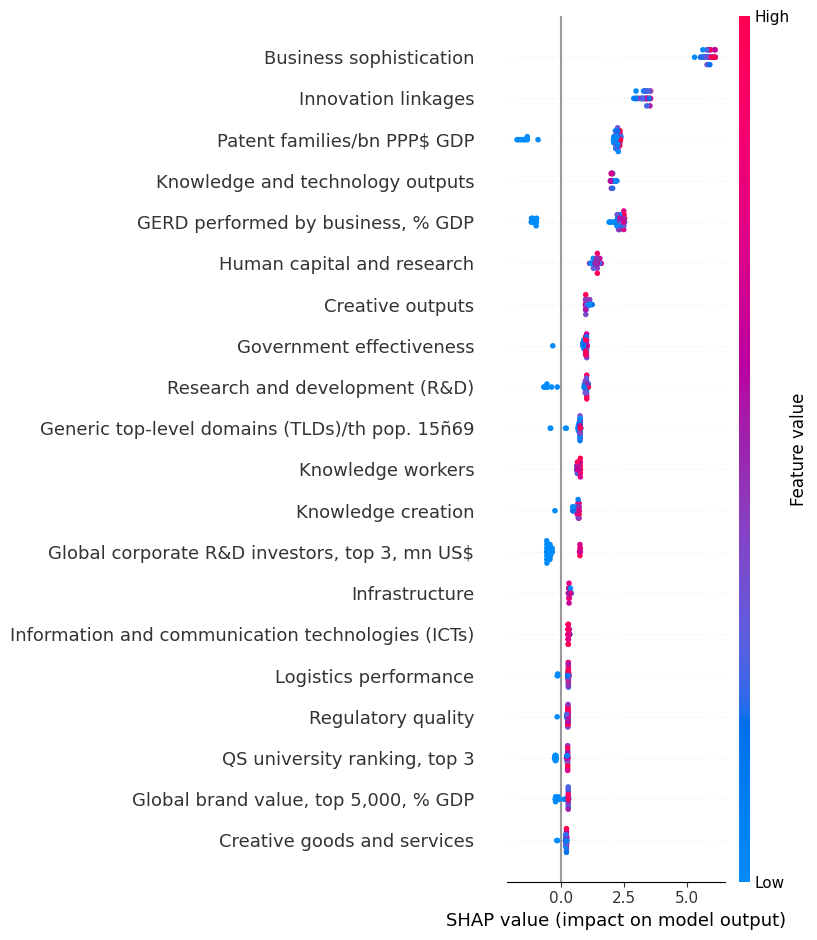

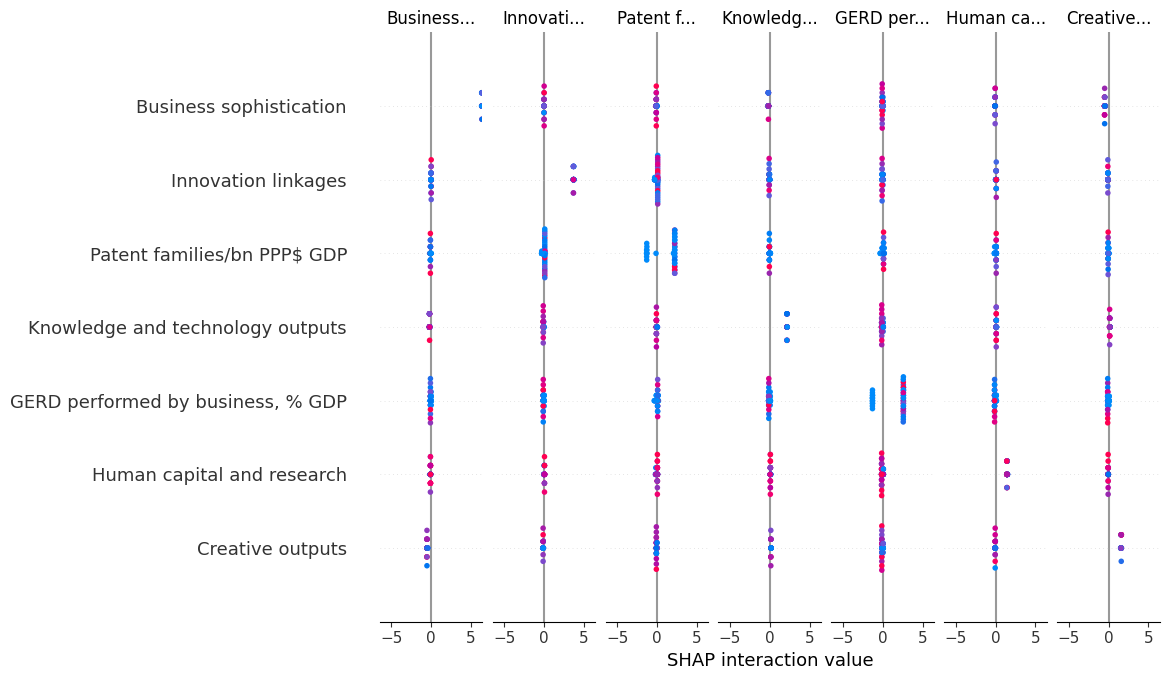

In [46]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Gráfico de resumen de SHAP
shap.summary_plot(shap_values, X_test, feature_names=keys_x)

# Fuerza de interacción
shap_interaction_values = explainer.shap_interaction_values(X_test)
shap.summary_plot(shap_interaction_values, X_test)

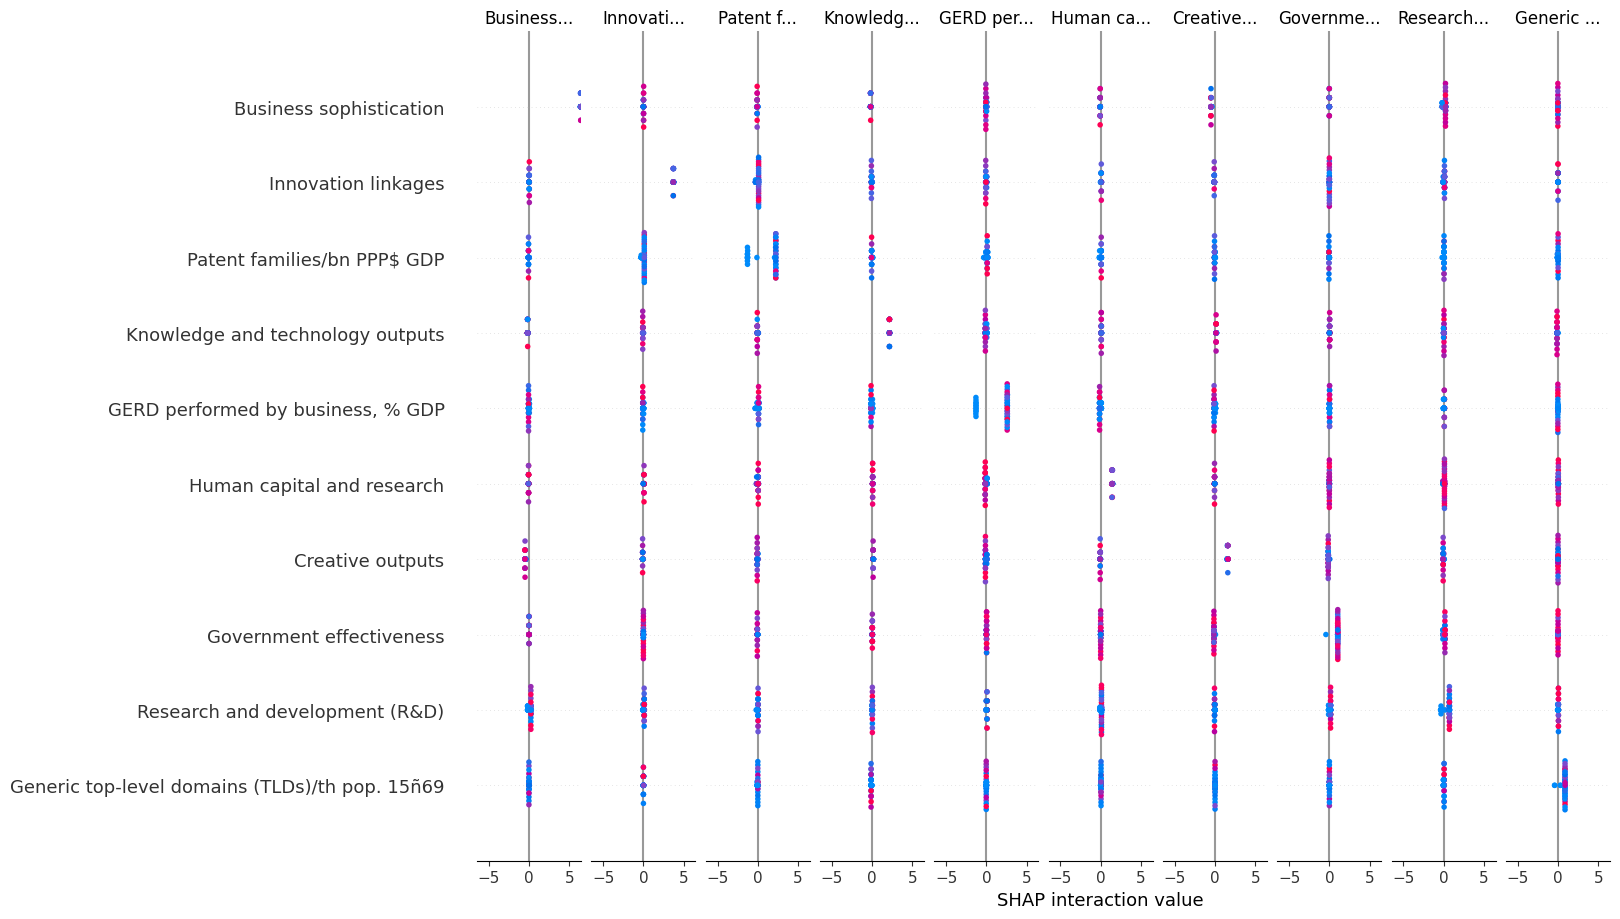

In [47]:
shap_interaction_values = explainer.shap_interaction_values(X_test)
shap.summary_plot(shap_interaction_values, X_test, max_display=10, feature_names=X.columns)

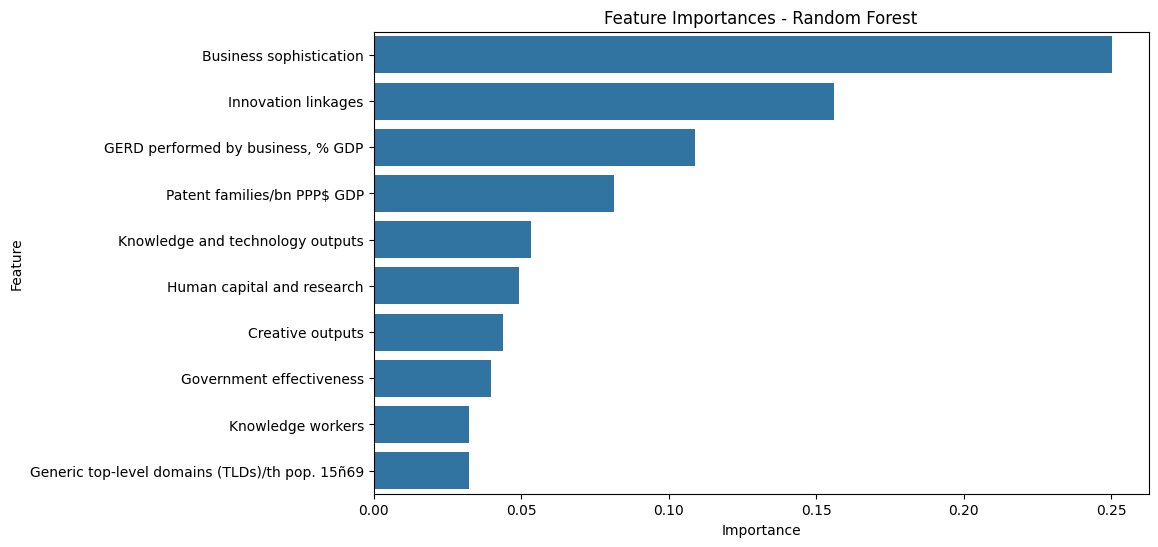

In [ ]:
importances = model.feature_importances_
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=features_df.head(10))
plt.title("Feature Importances - Random Forest")
plt.show()

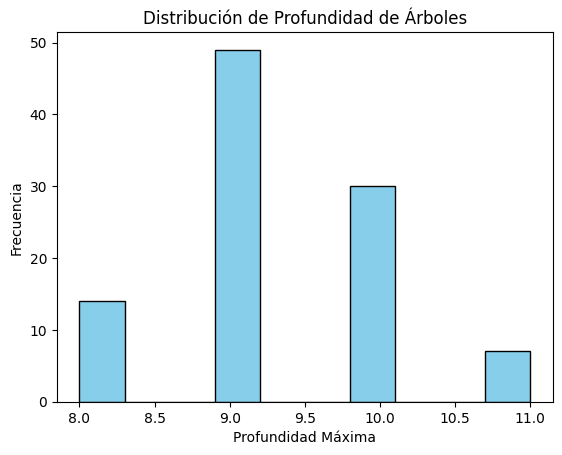

In [49]:
# Ejemplo de extracción de profundidad mínima
min_depths = [tree.tree_.max_depth for tree in model.estimators_]
plt.hist(min_depths, bins=10, color="skyblue", edgecolor="black")
plt.title("Distribución de Profundidad de Árboles")
plt.xlabel("Profundidad Máxima")
plt.ylabel("Frecuencia")
plt.show()

# **Explicaciones locales: Angola**

In [ ]:
# Crear el explainer con SHAP
explainer = shap.TreeExplainer(model)

# Obtener los valores SHAP para la predicción del nuevo dato
shap_values = explainer.shap_values(X_Angola)

# Visualizar la explicación para el primer dato de predicción
shap.initjs()  # Esto es necesario si trabajas en Jupyter Notebook para la visualización interactiva
shap.force_plot(explainer.expected_value[0], shap_values[0], X_Angola)
shap.save_html("explanation.html", shap.force_plot(explainer.expected_value[0], shap_values[0], X_Angola))

In [25]:
pred = model.predict(X_Angola)
print(f'La predicción del modelo para el GII de Angola es: {pred[0]:.2f}')

La predicción del modelo para el GII de Angola es: 44.21


In [47]:
explainer = shap.TreeExplainer(model)

# Seleccionar una instancia específica
angola_instances = X.loc['Angola']

if isinstance(angola_instances, pd.DataFrame):
    angola_instances = angola_instances.iloc[0] 

# Obtener los valores SHAP para la instancia seleccionada
shap_values = explainer(angola_instances)  # Esto devuelve un objeto `Explanation`

# Crear el gráfico de cascada (waterfall)
shap.plots.waterfall(shap_values[0, 0])

IndexError: too many indices for array

In [ ]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['output'],  # No hay clases, pero puedes usar un nombre genérico
    discretize_continuous=False,
    mode='regression'
)

# Generar explicación para una instancia específica
exp = explainer.explain_instance(
    angola_instances.values,  # Asegúrate de que sea una fila (1D)
    model.predict,            # Cambiar predict_proba por predict
    num_features=X_train.shape[1]
)

# Extraer las explicaciones en forma de lista (característica, contribución)
explanation_data = exp.as_list()

# Convertir las explicaciones en un DataFrame
explanation_df = pd.DataFrame(explanation_data, columns=["Feature", "Contribution"])

# Ordenar el DataFrame: primero positivos y luego negativos, de mayor a menor
explanation_df = explanation_df.sort_values(
    by="Contribution", ascending=False, key=lambda col: col.abs()
)

# Mostrar solo la tabla ordenada
explanation_df.sort_values(by='Contribution', ascending=False).head(10)

,Feature,Contribution
0,Patent families/bn PPP$ GDP,1.480895
1,"GERD performed by business, % GDP",1.064914
2,Research and development (R&D),0.632169
3,"Global corporate R&D investors, top 3, mn US$",0.618442
4,Knowledge creation,0.471419
5,Knowledge and technology outputs,0.422432
6,Generic top-level domains (TLDs)/th pop. 15ñ69,0.352744
7,Business sophistication,0.327006
8,Innovation linkages,0.314074
9,"Global brand value, top 5,000, % GDP",0.253254


In [66]:
explanation_df.sort_values(by='Contribution', ascending=False).tail(10)

,Feature,Contribution
52,National feature films/mn pop. 15ñ69,-0.039015
51,Rule of law,-0.039651
47,"Venture capital received, value, % GDP\r\n",-0.041842
46,ISO 9001 quality certificates/bn PPP$ GDP,-0.042887
38,Credit,-0.052103
36,ISO 14001 environmental certificates/bn PPP$ GDP,-0.053130
31,"Domestic market scale, bn PPP$",-0.060925
28,"High-tech exports, % total trade",-0.065000
26,"Females employed w/advanced degrees, %",-0.066368
24,New businesses/th pop. 15ñ64,-0.069395


In [67]:
exp.show_in_notebook(show_all=False)

## **DICE**

In [102]:
# 3. Contrafactuales (DICE)
# Preprocesamiento para DICE (necesario para variables categóricas)
import dice_ml

d = dice_ml.Data(dataframe=df, outcome_name=' Global Innovation Index')
m = dice_ml.Model(model=model, backend="sklearn")
exp = dice_ml.Dice(d, m, method="random")

# Generar contrafactuales
angola_instances = X.loc['Angola']  # Seleccionar la fila para Angola
query_instance = angola_instances.values.reshape(1, -1)  # Reshape para DICE, si es necesario

# Convertir 'angola_instances' a un DataFrame de una sola fila
angola_instances_df = angola_instances.to_frame().T

# Generar contrafactuales
dice_exp = exp.generate_counterfactuals(angola_instances_df, total_CFs=5, desired_class="opposite")

# Mostrar el DataFrame con los contrafactuales generados
print(dice_exp.cf_examples_list[0].final_cfs_df)

# Mostrar el gráfico si es necesario
plt.show()

ValueError: continuous_features should be provided

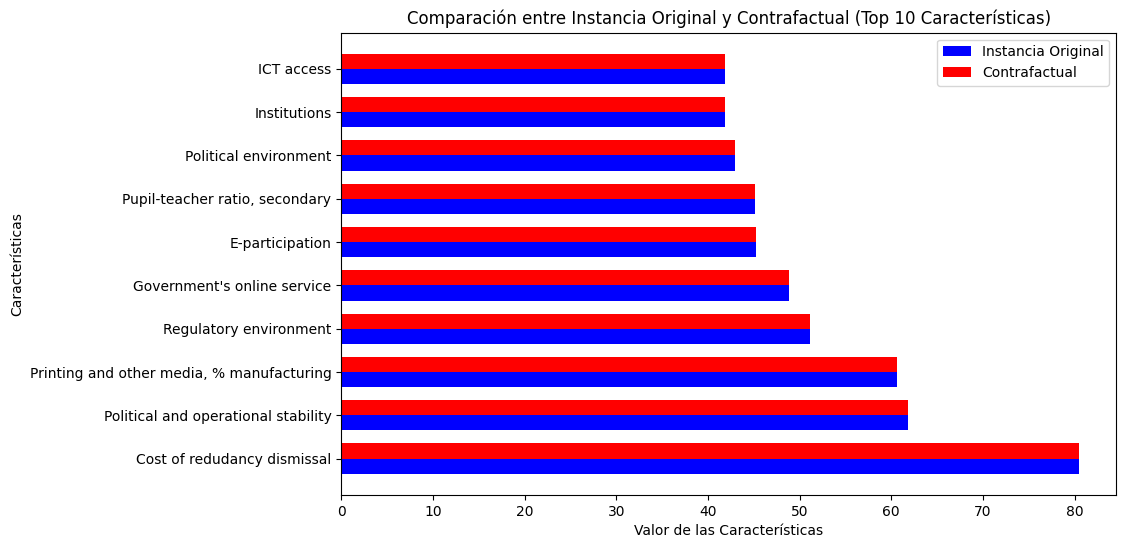

Cost of redudancy dismissal                  80.5
Political and operational stability          61.8
Printing and other media, % manufacturing    60.6
Regulatory environment                       51.1
Government's online service                  48.8
E-participation                              45.2
Pupil-teacher ratio, secondary               45.1
Political environment                        43.0
Institutions                                 41.9
ICT access                                   41.9
Name: 0, dtype: float64
Cost of redudancy dismissal                  80.5
Political and operational stability          61.8
Printing and other media, % manufacturing    60.6
Regulatory environment                       51.1
Government's online service                  48.8
E-participation                              45.2
Pupil-teacher ratio, secondary               45.1
Political environment                        43.0
Institutions                                 41.9
ICT access                

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd

# Tomar la instancia original de Angola (esto debe ser un dataframe o serie)
angola_instance = X.loc['Angola'].values
# Objetivo: cambiar la predicción a una clase opuesta (por ejemplo, 0)
desired_class = 0

# Función objetivo para optimizar: queremos minimizar la diferencia de la predicción
def objective_function(modified_instance):
    # Realizamos la predicción con la instancia modificada
    pred = model.predict([modified_instance])[0]
    # El objetivo es que la predicción sea igual al 'desired_class'
    return abs(pred - desired_class)

# Realizar la optimización para encontrar el contrafactual
result = minimize(objective_function, angola_instance, method='Nelder-Mead')

# Obtener la instancia contrafactual
modified_instance = result.x

# Convertimos las características a un dataframe para facilitar la visualización
angola_df = pd.DataFrame([angola_instance], columns=X.columns)
modified_df = pd.DataFrame([modified_instance], columns=X.columns)

# Ordenar las características de la instancia contrafactual por valor
sorted_indices = np.argsort(modified_instance)[::-1]  # Ordenar en orden descendente
top_10_indices = sorted_indices[:10]  # Seleccionar los 10 más altos

# Seleccionar las 10 características con mayor valor
top_10_features = modified_df.columns[top_10_indices]
top_10_values = modified_df.iloc[0, top_10_indices]

# Obtener los valores de la instancia original para las mismas características
angola_top_10_values = angola_df.iloc[0, top_10_indices]

# Graficar
plt.figure(figsize=(10, 6))

# Posicionar las barras de la instancia original y contrafactual (desplazadas para que no se superpongan)
bar_width = 0.35  # Ancho de las barras
index = np.arange(len(top_10_features))  # Posiciones de las barras

# Graficar las barras para la instancia original (azul)
plt.barh(index - bar_width/2, angola_top_10_values, bar_width, color='blue', label='Instancia Original')

# Graficar las barras para la instancia contrafactual (roja)
plt.barh(index + bar_width/2, top_10_values, bar_width, color='red', label='Contrafactual')

# Títulos y etiquetas
plt.xlabel('Valor de las Características')
plt.ylabel('Características')
plt.title('Comparación entre Instancia Original y Contrafactual (Top 10 Características)')
plt.yticks(index, top_10_features)  # Colocar los nombres de las características en el eje Y
plt.legend()

# Mostrar el gráfico
plt.show()
print(angola_top_10_values)
print(top_10_values)

# **Explicaciones Globales vs Locales**